In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
import tensorflow as tf

df1 = pd.read_json('input/Sarcasm_Headlines_Dataset.json',lines=True)
df2 = pd.read_json("input/Sarcasm_Headlines_Dataset_v2.json",lines=True)

df = pd.concat([df1, df2], axis = 0, ignore_index = True)
#df.to_csv()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


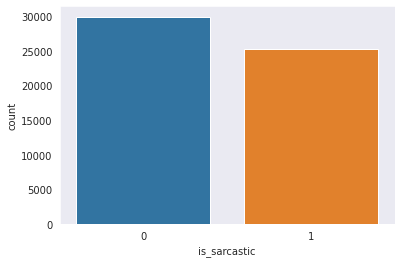

In [7]:
#Data Visualization and Preprocessing

df.isna().sum
del df['article_link']
df.head()
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [8]:
#Ignoring Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
#Basic Data Cleaning
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

#Removing square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

#Removing URL's
def remove_between_square_brackets(text):
  return re.sub(r'http\S+', '', text)

#Removing stopwords from text
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
      final_text.append(i.strip())
  return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  text = remove_stopwords(text)
  return text

#Apply function on review column
df['headline'] = df['headline'].apply(denoise_text)


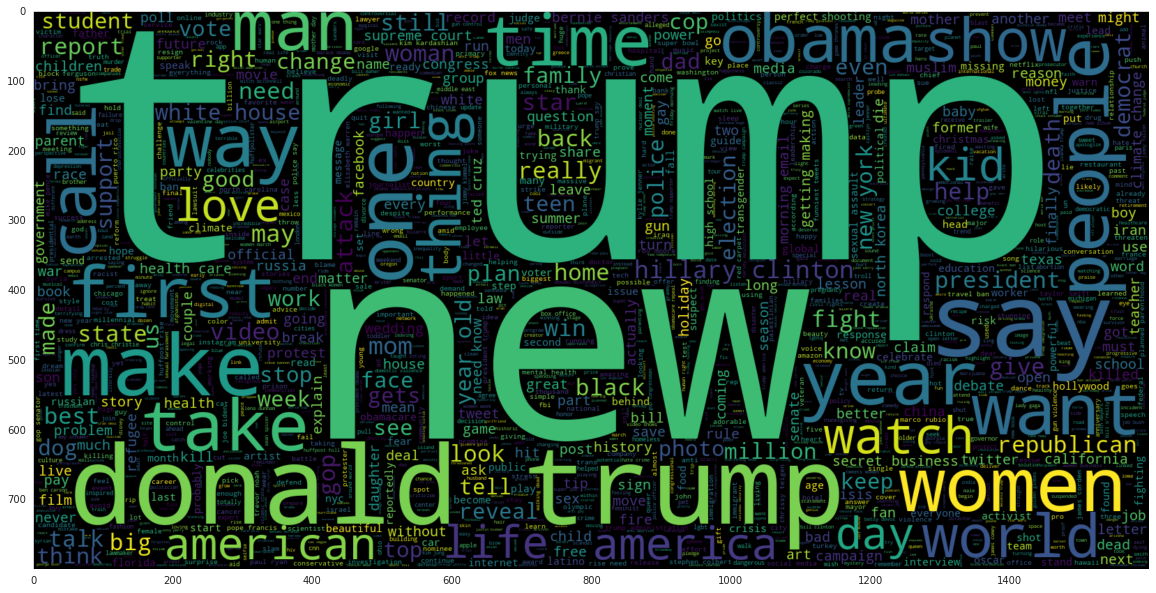

In [10]:
#Wordcloud not sarcastic
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc, interpolation = 'bilinear')

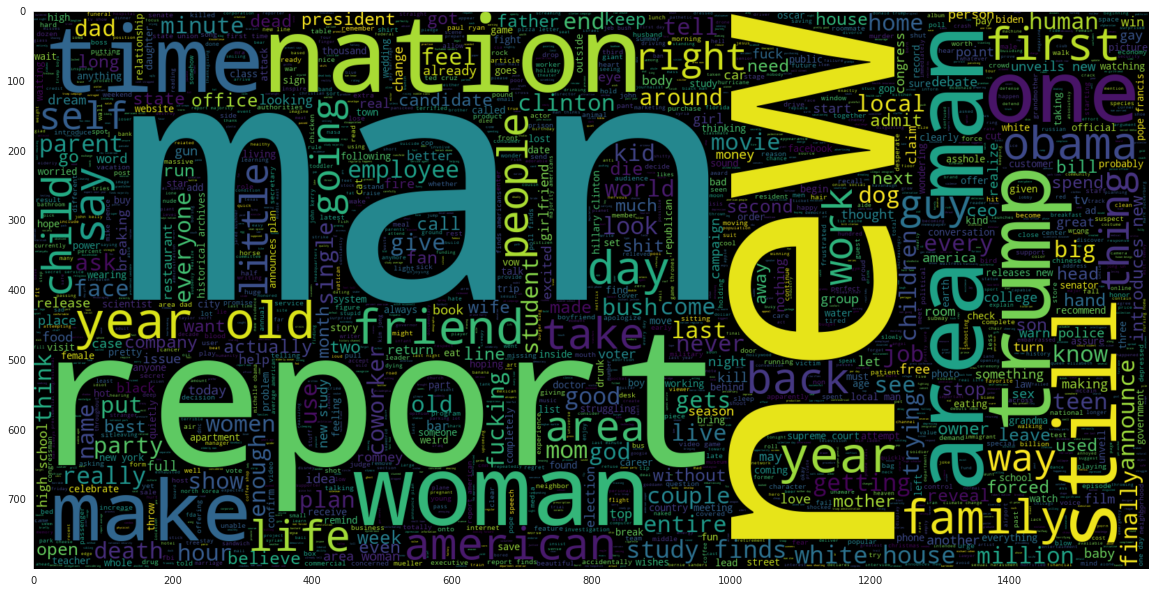

In [11]:
#Wordcloud sarcastic
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation = 'bilinear')

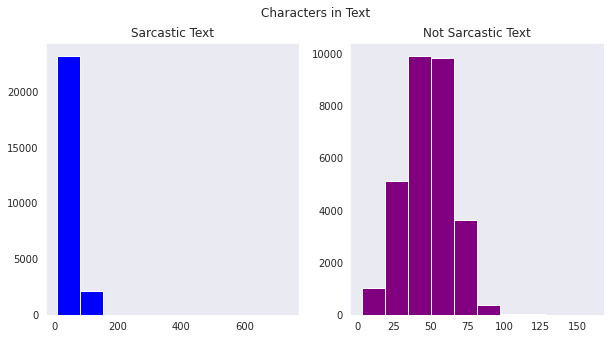

In [12]:
#Number of characters in texts
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

text_len = df[df['is_sarcastic'] == 1]['headline'].str.len()
ax1.hist(text_len, color = 'blue')
ax1.set_title('Sarcastic Text')

text_len = df[df['is_sarcastic'] == 0]['headline'].str.len()
ax2.hist(text_len, color = 'purple')
ax2.set_title('Not Sarcastic Text')

fig.suptitle('Characters in Text')
plt.show()

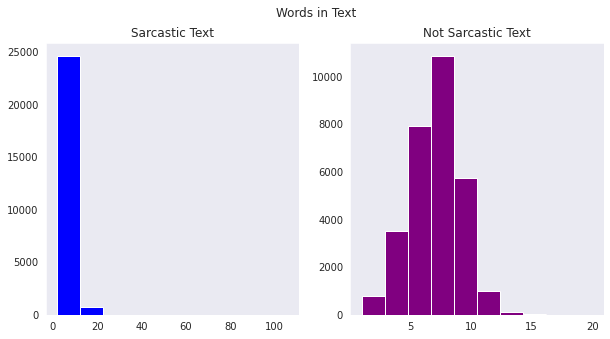

In [13]:
#Number or words in texts
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

text_len = df[df['is_sarcastic'] == 1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color = 'blue')
ax1.set_title('Sarcastic Text')


text_len = df[df['is_sarcastic'] == 0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color = 'purple')
ax2.set_title('Not Sarcastic Text')

fig.suptitle('Words in Text')
plt.show()

TypeError: ignored

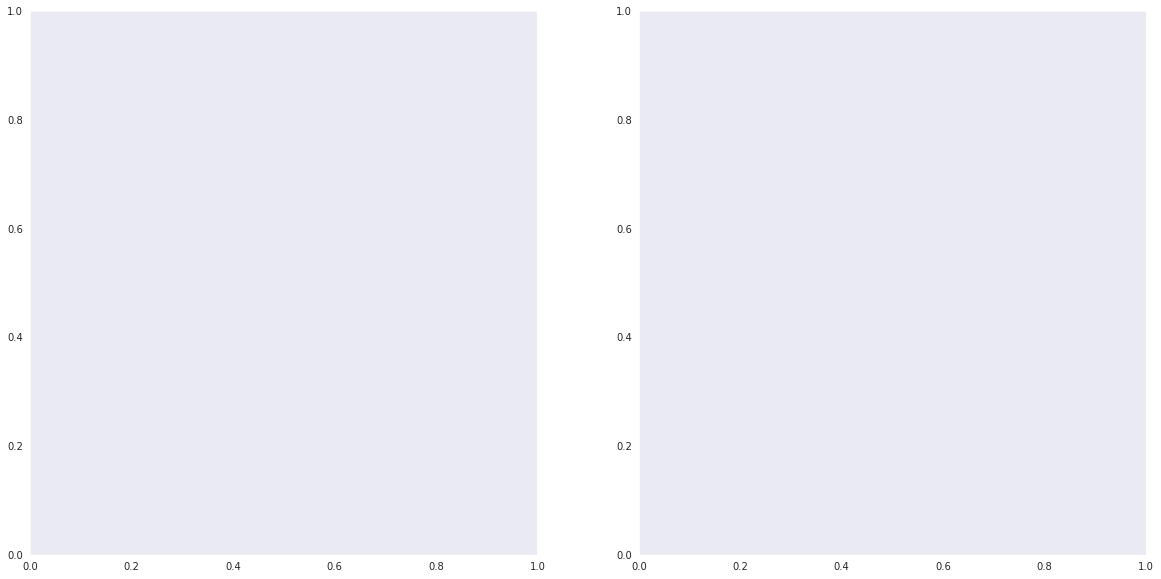

In [14]:
#Average words length in a text
#fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,10))

#word = df[df['is_sarcastic'] == 1]['headline'].str.split().apply(lambda x: [len(i) for i in x])
#sns.distplot(word.map(lambda x: np.mean(x), ax=ax1, color='blue'))
#ax1.set_title('Sarcastic Text')


#word = df[df['is_sarcastic'] == 0]['headline'].str.split().apply(lambda x: [len(i) for i in x])
#sns.distplot(word.map(lambda x: np.mean(x), ax=ax2, color='purple'))
#ax2.set_title('Sarcastic Text')

#fig.suptitle('Average word length in each text')


In [15]:
#Representing words as vectors with word2vec
words = []
for i in df.headline.values:
  words.append(i.split())
words[:5]


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [16]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences = words, size = EMBEDDING_DIM, window = 5, min_count = 1)

len(w2v_model.wv.vocab)

38071

In [17]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [18]:
vocab_size = len(tokenizer.word_index) + 1

In [19]:
def get_weight_matrix(model, vocab):
  vocab_size = len(vocab) + 1
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model[word]
  return weight_matrix

In [20]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
#Training Word2Vec Model

#Defining NN
model = Sequential()

#Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights = [embedding_vectors], input_length=20, trainable=True))

#LSTM
model.add(Bidirectional(LSTM(units = 128, recurrent_dropout = 0.3, dropout = 0.3, return_sequences = True)))
model.add(Bidirectional(GRU(units = 32, recurrent_dropout = 0.1, dropout = 0.1)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(lr = 0.01), loss = 'binary_crossentropy', metrics = ['acc'])

del embedding_vectors


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic, test_size = 0.3, random_state = 0)

In [25]:
history = model.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 3)

Epoch 1/3
303/303 [==============================] - 216s 575ms/step - loss: 0.5097 - acc: 0.7324 - val_loss: 0.2272 - val_acc: 0.9113
Epoch 2/3
303/303 [==============================] - 169s 557ms/step - loss: 0.0733 - acc: 0.9742 - val_loss: 0.2194 - val_acc: 0.9314
Epoch 3/3
303/303 [==============================] - 172s 567ms/step - loss: 0.0212 - acc: 0.9931 - val_loss: 0.3014 - val_acc: 0.9337


In [26]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

1211/1211 [==============================] - 31s 26ms/step - loss: 0.0061 - acc: 0.9985
Accuracy of the model on Training Data is -  99.8450756072998
519/519 [==============================] - 14s 26ms/step - loss: 0.3014 - acc: 0.9337
Accuracy of the model on Testing Data is -  93.3730959892273


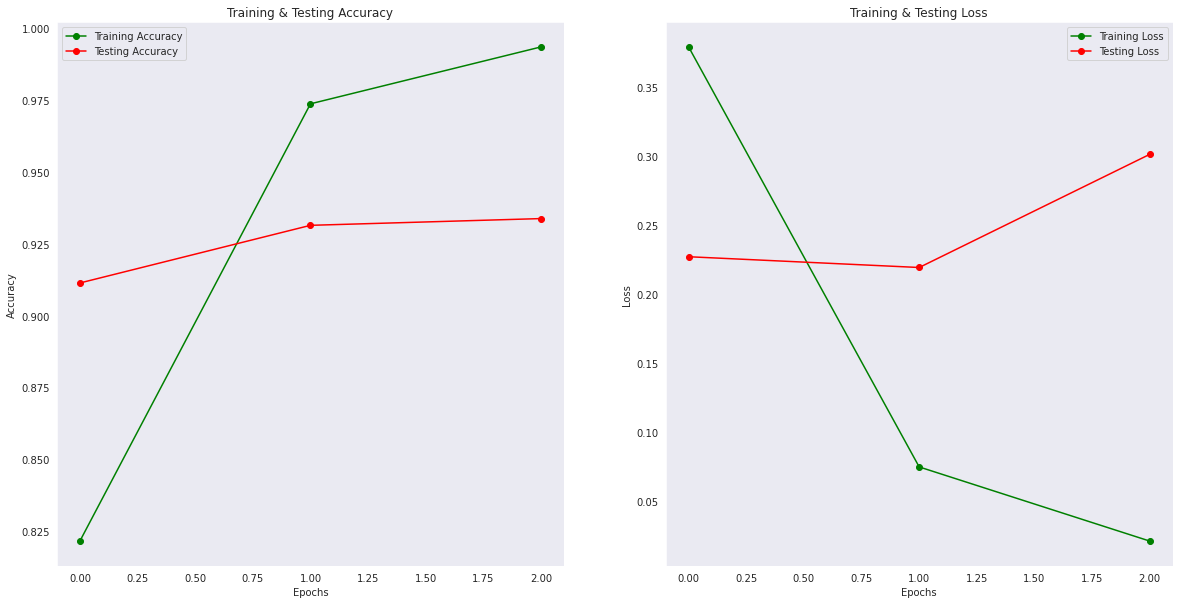

In [27]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [28]:
pred = model.predict_classes(x_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [29]:
cm = confusion_matrix(y_test,pred)
cm

array([[8554,  464],
       [ 636, 6945]])

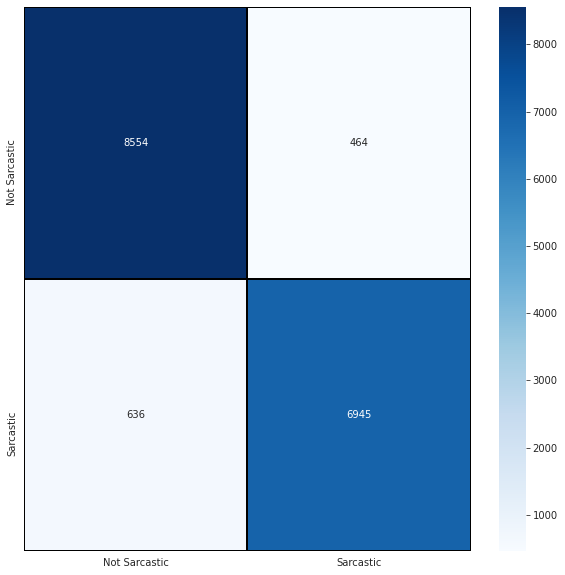

In [30]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])